# Chatbot With Neural Network

Tri Mulyani Ayuningtyas _ JumaTec

## Mendownload Dataset

In [ ]:
#download dataset
from urllib import request
url = "https://raw.githubusercontent.com/fendy07/chatbot-AI/master/kampus_merdeka.json"
request.urlretrieve(url, "kampus_merdeka.json")

('kampus_merdeka.json', <http.client.HTTPMessage at 0x7f4300916e90>)

## Load Gdrive

In [ ]:
#Load Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Menginstall Library

In [ ]:
#installasi Library
!pip -q install speechrecognition
!pip -q install gtts

     |████████████████████████████████| 32.8 MB 111 kB/s 


## Mengimport Library

In [ ]:
#import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

## Download NLTK Package

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Load Dataset Json

In [ ]:
# Importing the dataset
with open('/content/kampus_merdeka.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

## Menampilkan Semua Data

In [ ]:
#menampilkan data keseluruhan
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
75,Apa itu PMMB?,penjelasan_PMMB
76,Apa saja persyaratan IISMA?,persyaratan_IISMA
77,Bagaimana periode pelaksanaan dan cara mendaft...,periode_dan_pendaftaran_PMMB
78,Apa saja manfaat apabila mengikuti PMMB?,manfaat_PMMB


## Menampilkan baris pertama sampai baris kelima

In [ ]:
# Cetak data baris pertama sampai baris kelima
data.head()

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


## Menampilkan data baris ke -70 dampai baris terakhir

In [ ]:
# Cetak data baris ke-70 sampai baris akhir
data.tail(10)

,patterns,tags
70,Apa saja manfaat apabila mengikuti Pertukaran ...,manfaat_pertukaran_mahasiswa
71,Apa itu Pejuang Muda?,penjelasan_pejuang_muda
72,Apa saja persyaratan Pejuang Muda?,persyaratan_pejuang_muda
73,Bagaimana periode pelaksanaan dan cara mendaft...,periode_dan_pendaftaran_pejuang_muda
74,Apa saja manfaat apabila mengikuti Pejuang Muda?,manfaat_pejuang_muda
75,Apa itu PMMB?,penjelasan_PMMB
76,Apa saja persyaratan IISMA?,persyaratan_IISMA
77,Bagaimana periode pelaksanaan dan cara mendaft...,periode_dan_pendaftaran_PMMB
78,Apa saja manfaat apabila mengikuti PMMB?,manfaat_PMMB
79,Apa saja universitas yang tergabung dalam prog...,mitra_PMMB


## Remove Punctuations

In [ ]:
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower()for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## Lemmatization (Lematisasi)

In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print(len(words), "Unique lemmatized words", words)

78 Unique lemmatized words [',', 'afternoon', 'apa', 'apabila', 'bagaimana', 'bai', 'banyak', 'bersertifikat', 'bro', 'buat', 'bumn', 'bye', 'byee', 'cara', 'dadah', 'dah', 'dalam', 'dan', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hy', 'iisma', 'independen', 'itu', 'jumpa', 'kadek', 'kadekbot', 'kampus', 'kamu', 'kasih', 'kawan', 'kemendikbud', 'kemensos', 'magang', 'mahasiswa', 'makasih', 'malam', 'manfaat', 'mendaftar', 'mengajar', 'mengikuti', 'merdeka', 'mitra', 'morning', 'muda', 'pagi', 'pejuang', 'pelaksanaan', 'pembuatmu', 'penciptamu', 'periode', 'persyaratan', 'pertukaran', 'pmmb', 'program', 'saja', 'sampai', 'see', 'selamat', 'si', 'siang', 'siapa', 'sih', 'sore', 'studi', 'tergabung', 'terima', 'thank', 'thanks', 'tinggal', 'tujuan', 'universitas', 'yang', 'you']


## Menyortir Data Kelas Tags

In [ ]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

40 classes ['goodbye', 'greeting', 'kadekbot', 'manfaat_IISMA', 'manfaat_PMMB', 'manfaat_kampus_mengajar', 'manfaat_magang', 'manfaat_pejuang_muda', 'manfaat_pertukaran_mahasiswa', 'manfaat_studi_independen', 'mitra_IISMA', 'mitra_PMMB', 'mitra_magang', 'mitra_studi_independen', 'pencipta_kadekbot', 'penjelasan_IISMA', 'penjelasan_PMMB', 'penjelasan_kampus_mengajar', 'penjelasan_kampus_merdeka', 'penjelasan_magang', 'penjelasan_pejuang_muda', 'penjelasan_pertukaran_mahasiswa', 'penjelasan_studi_independen', 'periode_dan_pendaftaran_IISMA', 'periode_dan_pendaftaran_PMMB', 'periode_dan_pendaftaran_kampus_mengajar', 'periode_dan_pendaftaran_magang', 'periode_dan_pendaftaran_pejuang_muda', 'periode_dan_pendaftaran_pertukaran_mahasiswa', 'periode_dan_pendaftaran_studi_independen', 'persyaratan_IISMA', 'persyaratan_kampus_mengajar', 'persyaratan_kampus_merdeka', 'persyaratan_magang', 'persyaratan_pejuang_muda', 'persyaratan_pertukaran_mahasiswa', 'persyaratan_studi_independen', 'program_kamp

## Mencari Jumlah Keseluruhan Data Teks

In [ ]:
# documents = combination between patterns and intents
print (len(documents), "documents")

438 documents


## Tokenization (Tokenisasi)

In [ ]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [1, 6, 32],
 [29, 32],
 [29, 55],
 [33, 21, 56, 57, 29, 58],
 [29, 59, 33],
 [60],
 [61],
 [34],
 [62],
 [63, 34],
 [64, 65],
 [66, 67],
 [68],
 [69, 35],
 [70],
 [71, 35],
 [36, 37],
 [72],
 [36, 37, 73],
 [1, 6, 4, 5],
 [1, 74, 4, 5],
 [1, 7, 8, 4, 5],
 [1, 2, 3, 4, 5],
 [3, 4, 5, 75],
 [3, 4, 5, 76],
 [3, 4, 5, 77],
 [18, 19],
 [20],
 [4, 22],
 [9],
 [23, 24, 5],
 [25, 26],
 [27],
 [1, 6, 18, 19],
 [1, 2, 7, 18, 19],
 [10, 11, 12, 13, 14, 15, 3, 18, 19],
 [1, 2, 16, 17, 8, 18, 19],
 [1, 2, 38, 21, 30, 31, 18, 19],
 [1, 6, 20, 28],
 [1, 2, 7, 20, 28],
 [10, 11, 12, 13, 14, 15, 3, 20, 28],
 [1, 2, 16, 17, 8, 20, 28],
 [1, 2, 38, 21, 30, 31, 20, 28],
 [1, 6, 4, 22],
 [1, 2, 7, 4, 22],
 [10, 11, 12, 13, 14, 15, 3, 4, 22],
 [1, 2, 16, 17, 8, 4, 22],
 [1, 6, 9],
 [1, 2, 7, 9],
 [10, 11, 12, 13, 14, 15, 3, 9],
 [1, 2, 16, 17, 8, 9],
 [1, 2, 39, 21, 30, 31, 3, 9],
 [1, 6, 23, 24, 5],
 [

## Padding

In [ ]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[ 0  0  0  0  0  0  0  0  0 40]
 [ 0  0  0  0  0  0  0  0  0 41]
 [ 0  0  0  0  0  0  0  0  0 42]
 [ 0  0  0  0  0  0  0  0  0 43]
 [ 0  0  0  0  0  0  0  0  0 44]
 [ 0  0  0  0  0  0  0  0  0 45]
 [ 0  0  0  0  0  0  0  0  0 46]
 [ 0  0  0  0  0  0  0  0  0 47]
 [ 0  0  0  0  0  0  0  0  0 48]
 [ 0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 51]
 [ 0  0  0  0  0  0  0  0  0 52]
 [ 0  0  0  0  0  0  0  0  0 53]
 [ 0  0  0  0  0  0  0  0  0 54]
 [ 0  0  0  0  0  0  0  1  6 32]
 [ 0  0  0  0  0  0  0  0 29 32]
 [ 0  0  0  0  0  0  0  0 29 55]
 [ 0  0  0  0 33 21 56 57 29 58]
 [ 0  0  0  0  0  0  0 29 59 33]
 [ 0  0  0  0  0  0  0  0  0 60]
 [ 0  0  0  0  0  0  0  0  0 61]
 [ 0  0  0  0  0  0  0  0  0 34]
 [ 0  0  0  0  0  0  0  0  0 62]
 [ 0  0  0  0  0  0  0  0 63 34]
 [ 0  0  0  0  0  0  0  0 64 65]
 [ 0  0  0  0  0  0  0  0 66 67]
 [ 0  0  0  0  0  0  0  0  0 68]
 [ 0  0  0  0  0  0  0  0 69 35]
 [ 0  0  0  0  0  0  0  0  0 70]
 [ 0  0  0

## Encoding Text

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2 14 14 14  0  0  0  0
  0  0  0  0  0 38 38 38 38 38 18 39 32 37 37 37 37 37 37 37 37 37 37 37
 22 36 29  9 13 19 33 26  6 12 17 31 25  5 15 30 23  3 10 21 35 28  8 20
 34 27  7 16 30 24  4 11]


## Input Length, Output Length and Vocabulary

In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

10


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  77
output length:  40


## Save Model Words & Classes

In [ ]:
pickle.dump(words, open('/content/drive/MyDrive/msib/words.pkl','wb'))
pickle.dump(classes, open('/content/drive/MyDrive/msib/classes.pkl','wb'))

## Save Label Encoder & Tokenizer

In [ ]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

## Neural Network Model

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

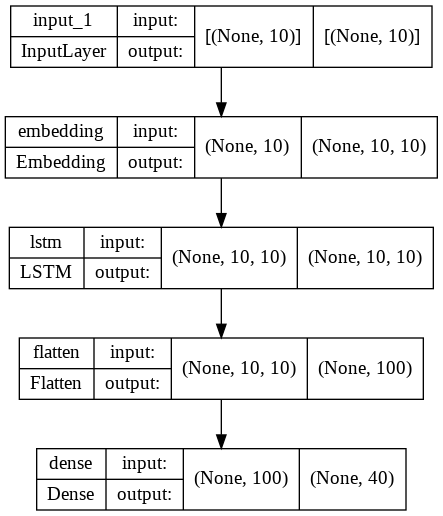

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Menampilkan Parameter Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 10)            780       
                                                                 
 lstm (LSTM)                 (None, 10, 10)            840       
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 40)                4040      
                                                                 
Total params: 5,660
Trainable params: 5,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
3/3 [==============================] - 2s 8ms/step - loss: 3.6881 - accuracy: 0.0000e+00
Epoch 2/400
3/3 [==============================] - 0s 11ms/step - loss: 3.6826 - accuracy: 0.0125
Epoch 3/400
3/3 [==============================] - 0s 9ms/step - loss: 3.6766 - accuracy: 0.0125
Epoch 4/400
3/3 [==============================] - 0s 7ms/step - loss: 3.6697 - accuracy: 0.0125
Epoch 5/400
3/3 [==============================] - 0s 7ms/step - loss: 3.6612 - accuracy: 0.0125
Epoch 6/400
3/3 [==============================] - 0s 8ms/step - loss: 3.6508 - accuracy: 0.0625
Epoch 7/400
3/3 [==============================] - 0s 7ms/step - loss: 3.6377 - accuracy: 0.1375
Epoch 8/400
3/3 [==============================] - 0s 12ms/step - loss: 3.6226 - accuracy: 0.1375
Epoch 9/400
3/3 [==============================] - 0s 7ms/step - loss: 3.6019 - accuracy: 0.1375
Epoch 10/400
3/3 [==============================] - 0s 8ms/step - loss: 3.5787 - accuracy: 0.1375
Epoch 11/400
3/3 [=====

## Model Analysis

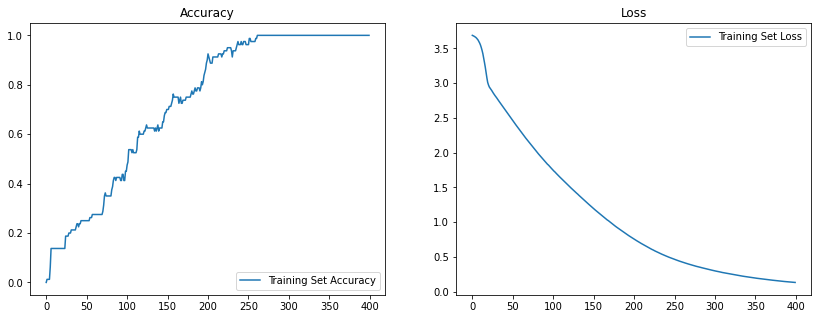

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc = 'upper right')
plt.title('Loss')
plt.show()

## Testing Chatbot Dan Tambahkan Suara Pada Chatbot

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)


  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 KadekBot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
  tts.save('/content/drive/MyDrive/msib/KadekBot.wav')
  time.sleep(0.08)
  # Load model voice bot from Google Drive
  ipd.display(ipd.Audio('/content/drive/MyDrive/msib/KadekBot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : abdullah latif
🤖 KadekBot :  Helo! Ini Kadekbot. Lagi kepo tentang kampus merdeka ya?



👨‍🦰 Kamu : kampus merdeka
🤖 KadekBot :  Mau tau tentang apa nih?



👨‍🦰 Kamu : goodbye
🤖 KadekBot :  Helo! Ini Kadekbot. Lagi kepo tentang kampus merdeka ya?



👨‍🦰 Kamu : goodbye
🤖 KadekBot :  Halo! Saya Kadekbot, salam kenal ya! Mau tau tentang kampus merdeka, kan?



👨‍🦰 Kamu : goodbye
🤖 KadekBot :  Hai! Kadekbot di sini. Mau tau informasi tentang apa nih?



👨‍🦰 Kamu : iya
🤖 KadekBot :  Halo! Saya Kadekbot, salam kenal ya! Mau tau tentang kampus merdeka, kan?



👨‍🦰 Kamu : goodbye
🤖 KadekBot :  Hai! Kadekbot di sini. Mau tau informasi tentang apa nih?


KeyboardInterrupt: ignored

Save The Model

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('/content/drive/MyDrive/msib/chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!
